In [1]:
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def loadData(fileNameStr):
    df = pd.read_csv(fileNameStr,sep=' ', header=None)
    df.columns = ['cityNumber', 'x', 'y']
    xs = df.y
    ys = df.x
    return xs, ys

In [3]:
#functions used to build the distance matrix
def distanceScalar(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def createDistanceMatrix(xs, ys):
    numPoints = len(xs)
    dists = np.ndarray((numPoints,numPoints))
    for i in range(numPoints):
        dists[i,i] = 0
        for j in range(i+1,numPoints):
            dists[i,j] = distanceScalar(xs[i], ys[i], xs[j], ys[j])
            dists[j,i] = dists[i,j]   
    return dists

In [4]:
def routeLength(path, distancesMatrix):
    # index 0 not included in the path as we're assuming 0 is starting point
    curLength = distancesMatrix[0,path[0]]
    for i in range(len(path)-1):
        curLength += distancesMatrix[path[i], path[i+1]]
    curLength += distancesMatrix[path[-1],0]
    return curLength

In [5]:
def visualiseRoute(xs, ys, path, routeLength):
    fig, ax = plt.subplots(1,1)
    dash = [5, 5]
    ax.scatter(xs[0],ys[0], color='black')
    ax.scatter(xs[1:], ys[1:], color='blue')
    ax.plot([xs[0],xs[path[0]]],[ys[0],ys[path[0]]], color='red', dashes=dash)
    for i in range(numPoints-2):
        ax.plot([xs[path[i]],xs[path[i+1]]],[ys[path[i]],ys[path[i+1]]], color='red', dashes=dash)
    ax.plot([xs[0],xs[path[-1]]],[ys[0],ys[path[-1]]], color='red', dashes=dash)    
    ax.set_title('Route length: {:.3}'.format(routeLength))

In [6]:
class TSP_evaluator:
    # helper class for simulated annealing algorithm
    def __init__(self, distMatrix):
        self.mDists = distMatrix
        self.dim = distMatrix.shape[0]
        self.pool = [i for i in range(self.dim-1)]
        
    def evaluate(self, path):
        # Returns the path length
        return routeLength(path, self.mDists)
    
    def randomSolution(self, initSolution):
        # Returns a random solution around initSolution
        return self.rebranching(initSolution)
    
    def rebranching(self, initSolution):
        # Given a current solution [c1, c2, ..., ck1, ck1+1, ...,  ck2-1, ck2, ..., cn]
        # returns a new solution [c1, c2, ..., ck2, ck2-1, ..., ck1+1, ck1, ..., cn ]
        # where k1 and k2 are chosen randomly
        
        k1, k2 = random.sample(self.pool, 2)
        k1, k2 = min(k1,k2), max(k1, k2)
        newSolution = list(initSolution)
        for l in range(1+int(0.5*(k2-k1-1))):
            newSolution[k1+l], newSolution[k2-l] = newSolution[k2-l], newSolution[k1+l]
        return newSolution


In [7]:
def simulatedAnnealing(objFun, minMax, xStart, initTemp, finalTemp, coolFactor, maxIterPerTemp):
    # objFun : the function to optimize
    # minMax : 1 to minimize, -1 to maximize
    # xStart: starting point of the search
    # initTemp: initial Temperature
    # finalTemp: finalTemperature
    # coolFactor: parameters <1
    #             At each step temperature change, new temp = current temp * coolFactor
    # searchRadius: the radius of the ball inside which we look for a solution. 
    #               When current temperature < 1, the new search radius = current search radius * coolFactor
    # maxIterTemp: the maximum number of iterations we perform once we found a new optimum at a given temperature
    #              This defines the equilibrium condition at a given temperature, ie we've iterated maxIterPerTemp 
    #              without finding a better solution
    
    # Note on implementation:
    # When the current temperature falls below 1, the search radius gets multiplied by the coolFactor
    # This allows for intensification when we're near the end of the algorithm
    
    # Please note this is a custom implementation of simulated annealing. It was implemented so as to 
    # allow better identification of which parameter to change when convergence isn't obtained.
    # To achieve this, the algorithm "normalizes" delta (the change in energy) using the average delta 
    # at the equilibrium position for a given temperature. This avoids having to adjust for initial temperatures
    # and final temperatures so that the order of magnitude depends on the energy delta. We get a better control
    # of the barrier level for diversification.
    
    curTemp = initTemp
    xBest = np.copy(xStart)
    fxBest = objFun.evaluate(xBest) * minMax
    
    # to store all evaluated points and associated function values
    xIter = []
    fxIter = []
    
    # to store best x and f(xBest) for a given temperature
    bestxTemp = []
    bestfxTemp = []
    probs = []
        
    iterCount = 0
    while curTemp > finalTemp:
        #restarting from our equilibrium point (ie best value so far)
        x = np.copy(xBest)
        fx = fxBest
        iterCount = 0
        deltaAvg = 0
        probVec = []
        
        #we reach equilibrium at this temperature if we iterated maxIterPerTemp times without improving the best solution
        while iterCount < maxIterPerTemp:
            xTest = objFun.randomSolution(x)
            fxTest = objFun.evaluate(xTest) * minMax
            delta = fxTest - fx
            deltaAvg = (iterCount*deltaAvg+abs(delta))/(iterCount+1)
            
            if delta >0:
                lim_prob = np.exp(-(delta/deltaAvg)/curTemp)
                probVec.append(lim_prob)

            if delta <= 0 or np.random.random() < np.exp(-(delta/deltaAvg)/curTemp):
                x = np.copy(xTest)
                fx = fxTest
            iterCount+=1
            if fxTest < fxBest:
                #we improved the best solution, reset iterCount to 0 and store new best solution 
                iterCount = 0
                deltaAvg = 0
                xBest = np.copy(xTest)
                fxBest = fxTest

            xIter.append(x)
            fxIter.append(objFun.evaluate(x))
        bestxTemp.append(xBest)
        bestfxTemp.append(objFun.evaluate(xBest))
        probs.append(np.mean(probVec))

        curTemp *= coolFactor

    return bestxTemp, bestfxTemp, xIter, fxIter, probs

In [8]:
fileName = 'Qatar_194_coordinates.tsp'
knownOptimum = 9352
xs, ys = loadData(r'.\\data\\' + fileName)
numPoints = len(xs)

dists = createDistanceMatrix(xs, ys)

In [9]:
tspEval = TSP_evaluator(dists)

initTemp = 5
finalTemp = 0.008
coolFactor = 0.9
maxIterTemp = 10 * numPoints

minMax = 1  #minimize = 1, maximize = -1

# start from a random solution
x = [i for i in range(1, numPoints)]
random.shuffle(x)

startTime = time.time()
paths, pathLengths, xEvals, fxEvals, probs = simulatedAnnealing(tspEval, minMax, x, initTemp, finalTemp, coolFactor, maxIterTemp)
runTime = time.time() - startTime

path = paths[-1]
pathLength = pathLengths[-1]

print('Path Length: {:.0f}'.format(pathLength))
print('True Minimum: {}'.format(knownOptimum))
print('Solution: {}'.format(path))
print('Computational time: {:.2f} s'.format(runTime))
print('Number of function evaluations: {}'.format(len(fxEvals)))


Path Length: 10547
True Minimum: 9352
Solution: [  1   3   6   2   4   8   9  11  14  18  29  31  30  41  49  34  43  48
  54  51  45  47  42  37  40  46  57  53  55  52  39  38  33  36  50  60
  67  65  66  72  83  99 104 106 107 109 111 114 115 116 117 120 119 122
 123 127 132 134 128 130 135 142 147 154 159 165 170 184 179 177 192 187
 190 188 191 189 186 193 181 175 168 155 160 162 163 171 178 185 182 172
 173 174 183 180 176 167 164 158 166 169 161 157 150 146 151 152 156 153
 149 143 140 121 137 138 145 148 144 141 136 139 133 131 125 124 126 129
 110 103 113 118 112 108 101 102 105  94  95  92  96  91  87  82  80  78
  76  63  69  59  56  32  44  27  28  26  21  17  20  23  25  16  10  13
  22  24  75  74  71  68  73  77  90  86  79  70  81  88  89  93 100  98
  97  85  84  64  19  62  35  58  61  15  12   7   5]
Computational time: 41.10 s
Number of function evaluations: 224466


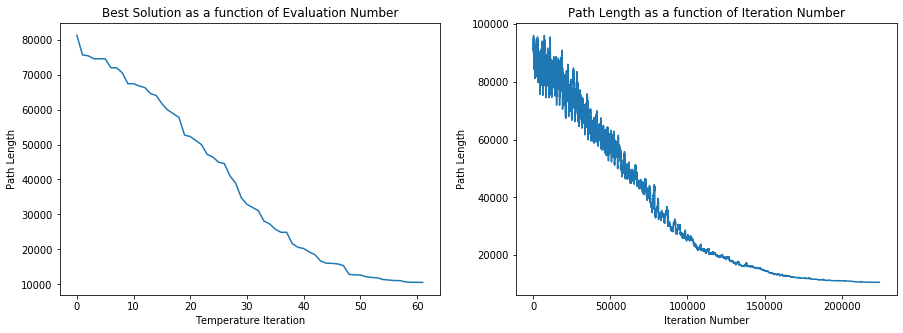

In [10]:
tempZoom = 0
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot([i for i in range(tempZoom, len(pathLengths))], np.array(pathLengths[tempZoom:]))
ax[1].plot([i for i in range(len(xEvals))], np.array(fxEvals))

ax[0].set_xlabel('Temperature Iteration')
ax[0].set_ylabel('Path Length')
ax[0].set_title('Best Solution as a function of Evaluation Number')

ax[1].set_xlabel('Iteration Number')
ax[1].set_ylabel('Path Length')
ax[1].set_title('Path Length as a function of Iteration Number')

plt.savefig('convergenceCurves')

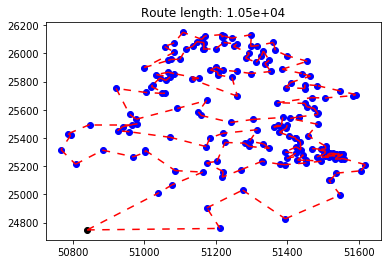

In [11]:
visualiseRoute(xs, ys, path, pathLength)
plt.savefig('Path')

In [12]:
# Solution:
print('city: {} \t x: {} \t y: {} '.format(0, xs[0], ys[0]))
for i in range(numPoints-1):
    print('city: {} \t x: {} \t y: {}  '.format(path[i], xs[path[i]], ys[path[i]]))

city: 0 	 x: 50840.0 	 y: 24748.3333 
city: 1 	 x: 51211.9444 	 y: 24758.8889  
city: 3 	 x: 51175.0 	 y: 24904.4444  
city: 6 	 x: 51275.2778 	 y: 25030.8333  
city: 2 	 x: 51394.7222 	 y: 24827.2222  
city: 4 	 x: 51548.8889 	 y: 24996.1111  
city: 8 	 x: 51516.6667 	 y: 25100.0  
city: 9 	 x: 51521.6667 	 y: 25103.3333  
city: 11 	 x: 51537.7778 	 y: 25150.8333  
city: 14 	 x: 51606.9444 	 y: 25167.7778  
city: 18 	 x: 51619.1667 	 y: 25211.3889  
city: 29 	 x: 51559.1667 	 y: 25252.5  
city: 31 	 x: 51549.7222 	 y: 25253.8889  
city: 30 	 x: 51535.2778 	 y: 25253.8889  
city: 41 	 x: 51547.7778 	 y: 25277.2222  
city: 49 	 x: 51555.2778 	 y: 25284.7222  
city: 34 	 x: 51545.2778 	 y: 25265.8333  
city: 43 	 x: 51541.3889 	 y: 25278.3333  
city: 48 	 x: 51546.6667 	 y: 25283.6111  
city: 54 	 x: 51546.6667 	 y: 25288.0556  
city: 51 	 x: 51534.1667 	 y: 25286.1111  
city: 45 	 x: 51535.0 	 y: 25281.1111  
city: 47 	 x: 51533.3333 	 y: 25283.3333  
city: 42 	 x: 51525.5556 	 y: 25278